<h1 style="text-align: center">Solving the N-Queens Problem with Genetic Programming</h1>

<hr style="border-top: 2px solid #444">

## Development Environment

### Python Dependencies

In [11]:
!pip install -r pipenv-requirements.txt
!pipenv install

Installing dependencies from Pipfile.lock (c4b027)â€¦



Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.



### Python Imports

In [12]:
import math
import random
import sys
from time import time
from typing import List, Tuple, Callable, TypeVar

import deap
import matplotlib.pyplot as pyplot
import numpy
import pandas
from IPython.display import display
from deap import algorithms, base, creator, tools

print(f"Python version: {sys.version}")
print(f"DEAP version: {deap.__version__}")
print(f"Numpy version: {numpy.__version__}")
print(f"Pandas version: {pandas.__version__}")

Python version: 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
DEAP version: 1.3
Numpy version: 1.19.2
Pandas version: 1.1.2


### Configure PRNG Seed

In [13]:
random.seed(42)

### Configure Pandas Table Truncation

In [14]:
pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.width', None)
pandas.set_option('display.max_colwidth', None)

<hr style="border-top: 2px solid #444">

## I. DEAP Toolkit

### Evolutionary Algorithm Function

In [15]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

T = TypeVar('T')
def evolution(*,
      individual_generator: Callable[[], T],
      fitness_evaluation: Callable[[T], float],
      population_size: int,
      generations: int,
      crossover_rate: float,
      mutation_rate: float,
      mutation_function: Tuple[Callable, dict],
):
    start_time = time()

    toolbox = base.Toolbox()

    # register population generators
    toolbox.register("individual", tools.initIterate, creator.Individual, individual_generator)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # register fitness evaluation function
    toolbox.register("evaluate", lambda individual: (fitness_evaluation(individual),))

    # register mutators for individuals
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutation_function[0], **mutation_function[1])

    # register next generation selection function
    toolbox.register("select", tools.selTournament, tournsize=4)

    # generation statistics logging
    stats = tools.Statistics(key=lambda individual: individual.fitness.values)
    stats.register("min", lambda population: numpy.min([fitness for fitness in population if fitness[0] != math.inf]))
    stats.register("avg", lambda population: numpy.mean([fitness for fitness in population if fitness[0] != math.inf]))
    stats.register("max", lambda population: numpy.max([fitness for fitness in population if fitness[0] != math.inf]))

    # log fittest individual with a hall of fame record
    hall_of_fame = tools.HallOfFame(maxsize=1)

    # run genetic algorithm
    _, log = algorithms.eaSimple(
        # generate all individuals in population
        toolbox.population(n=population_size),
        toolbox,
        ngen=generations,
        cxpb=crossover_rate, mutpb=mutation_rate,
        stats=stats, halloffame=hall_of_fame, verbose=False,
    )

    # return duration, statistics log, and the fittest individual
    return time() - start_time, log, hall_of_fame[0]

c:\users\concision\drive\development\github\n-queens\venv\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\users\concision\drive\development\github\n-queens\venv\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### Population Visualizer

In [16]:
def plot_generations(generation: List[int], average: List[float], minimum: List[int], maximum: List[int]):
    pyplot.figure(figsize=(16, 8))
    pyplot.grid(True)
    pyplot.plot(generation, average, label="average")
    pyplot.plot(generation, minimum, label="minimum")
    pyplot.plot(generation, maximum, label="maximum")
    pyplot.xlabel("Generation")
    pyplot.ylabel("Fitness")
    pyplot.ylim(-1)
    pyplot.legend(loc="upper right")
    pyplot.show()

<hr style="border-top: 2px solid #444">

## II. Position-indexed Board Encoding
- For an 8x8 board, there are (8^2)^8 possible states: 281,474,976,710,656
- For an 16x16 board, there are (16^2)^16 possible states: 340,282,366,920,938,463,463,374,607,431,768,211,456

### Rendering Position-indexed Board

In [17]:
def display_positional_grid(individual: List[int]):
    # unpack dimensions
    dimension = len(individual)

    # construct board using pandas
    board = pandas.DataFrame("", index = range(1, dimension + 1), columns = range(1, dimension + 1))

    # draw all conflicts with a red line
    for x in range(dimension):
        x_row, x_column = individual[x] // dimension, individual[x] % dimension
        for y in range(x + 1, dimension):
            y_row, y_column = individual[y] // dimension, individual[y] % dimension

            diff_row, diff_column = y_row - x_row, y_column - x_column
            # check if queens are conflicting
            if x_row == y_row or x_column == y_column or abs(diff_row) == abs(diff_column):
                # draw a line of the conflict
                for i in range(1 + max(abs(diff_row), abs(diff_column))):
                    board[1 + x_column + i * numpy.sign(diff_column)][1 + x_row + i * numpy.sign(diff_row)] = "🟥"

    # draw all queens
    for queen in individual:
        row, column = queen // dimension, queen % dimension
        # use a crown if
        board[1 + column][1 + row] = "👑" if board[1 + column][1 + row] == "" else "♕"

    # render board with pandas
    display(board)

### Example 8x8 Position-indexed Individual

In [18]:
example_individual = random.sample(range(8**2), 8)
print(f"Positions: {example_individual}")
print(f"Duplicate positions: {len(example_individual) - len(set(example_individual))}")
display_positional_grid(example_individual)

Positions: [14, 1, 47, 17, 15, 63, 8, 61]
Duplicate positions: 0


,1,2,3,4,5,6,7,8
1,,♕,,,,,,
2,♕,🟥,🟥,🟥,🟥,🟥,♕,♕
3,,♕,,,,,,🟥
4,,,,,,,,🟥
5,,,,,,,,🟥
6,,,,,,,,♕
7,,,,,,,🟥,🟥
8,,,,,,♕,🟥,♕


### Position-indexed Fitness Evaluation Function
Time complexity: `O(|queens|^2)`

In [19]:
def evaluate_position_indexed_fitness(individual: List[int]) -> float:
    # duplicate values should be removed with the severest penalty
    if len(individual) != len(set(individual)):
        return math.inf

    # unpack dimensions
    dimension = len(individual)
    # count all pairs of conflicts
    fitness: float = 0
    for x in range(len(individual)):
        x_row, x_column = individual[x] // dimension, individual[x] % dimension
        for y in range(x + 1, len(individual)):
            y_row, y_column = individual[y] // dimension, individual[y] % dimension
            if x_row == y_row or x_column == y_column or abs(x_row - y_row) == abs(x_column - y_column):
                fitness += 1
    return fitness

### Evolutionary Algorithm on a 8x8 Board

#### Evolutionary Computation

Computed in 11.046 seconds


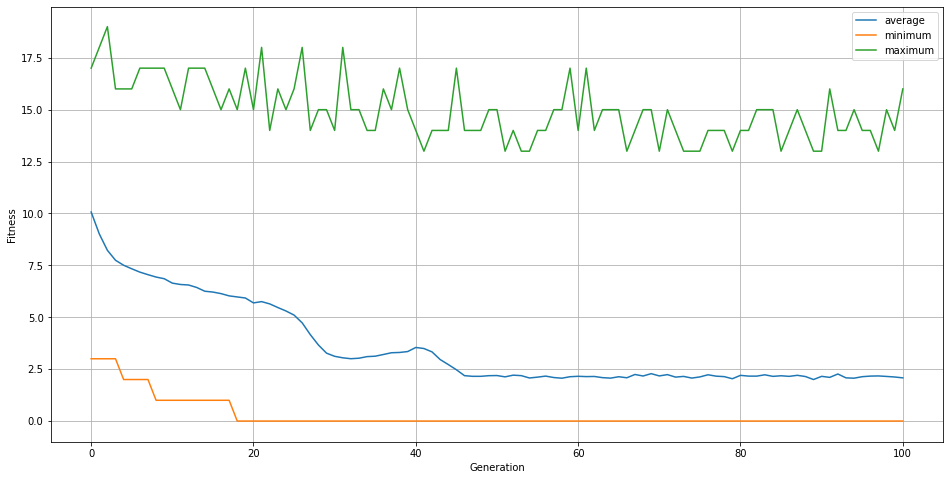

In [20]:
duration, log, fittest_individual_p8 = evolution(
    individual_generator=lambda: random.choices(range(8**2), k=8),
    fitness_evaluation=evaluate_position_indexed_fitness,
    population_size=2500,
    generations=100,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 8**2 - 1, "indpb": .25})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [21]:
print(f"Positions: {fittest_individual_p8}")
print(f"Duplicate queens: {len(fittest_individual_p8) - len(set(fittest_individual_p8))}")
print(f"Fitness: {abs(fittest_individual_p8.fitness.values[0])}")
display_positional_grid(fittest_individual_p8)

Positions: [24, 44, 7, 9, 38, 61, 50, 19]
Duplicate queens: 0
Fitness: 0.0


,1,2,3,4,5,6,7,8
1,,,,,,,,👑
2,,👑,,,,,,
3,,,,👑,,,,
4,👑,,,,,,,
5,,,,,,,👑,
6,,,,,👑,,,
7,,,👑,,,,,
8,,,,,,👑,,


### Evolutionary Algorithm on a 16x16 Board

#### Evolutionary Computation

Computed in 186.354 seconds


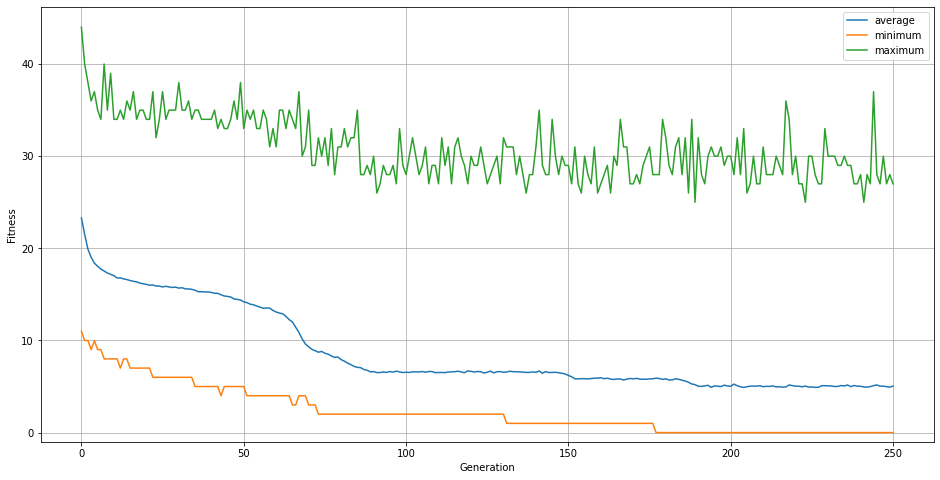

In [22]:
duration, log, fittest_individual_p16 = evolution(
    individual_generator=lambda: random.choices(range(16**2), k=16),
    fitness_evaluation=evaluate_position_indexed_fitness,
    population_size=10000,
    generations=250,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 16**2 - 1, "indpb": .25})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [23]:
print(f"Positions: {fittest_individual_p16}")
print(f"Duplicate queens: {len(fittest_individual_p16) - len(set(fittest_individual_p16))}")
print(f"Fitness: {abs(fittest_individual_p16.fitness.values[0])}")
display_positional_grid(fittest_individual_p16)

Positions: [80, 251, 209, 150, 188, 110, 237, 68, 130, 163, 7, 47, 121, 56, 202, 21]
Duplicate queens: 0
Fitness: 0.0


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,,,,,,,,👑,,,,,,,,
2,,,,,,👑,,,,,,,,,,
3,,,,,,,,,,,,,,,,👑
4,,,,,,,,,👑,,,,,,,
5,,,,,👑,,,,,,,,,,,
6,👑,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,👑,
8,,,,,,,,,,👑,,,,,,
9,,,👑,,,,,,,,,,,,,
10,,,,,,,👑,,,,,,,,,


### Notes
- Despite higher population and generation counts, this board representation suffers for larger board sizes

<hr style="border-top: 2px solid #444">

## III. Row-index Board Encoding

- For an 8x8 board, there are 8^8 possible states: 16,777,216
- For an 16x16 board, there are 16^16 possible states: 18,446,744,073,709,551,616

### Rendering Row-indexed Board

In [24]:
def display_row_grid(individual: List[int]):
    dimension = len(individual)
    display_positional_grid([dimension * i + individual[i] for i in range(dimension)])

### Example 8x8 Row-indexed Individual

In [25]:
example_individual = random.sample(range(8), 8)
print(f"Positions: {example_individual}")
display_row_grid(example_individual)

Positions: [0, 7, 5, 3, 6, 4, 2, 1]


,1,2,3,4,5,6,7,8
1,♕,,,,,,,
2,,🟥,,,,,,♕
3,,,🟥,,,👑,🟥,
4,,,,♕,,🟥,,
5,,,,,🟥,,👑,
6,,,,🟥,👑,,,
7,,,♕,,,,,
8,,♕,,,,,,


### Row-indexed Fitness Evaluation Function
Time complexity: `O(|queens|^2)`

In [26]:
def evaluate_row_indexed_fitness(individual: List[int]) -> float:
    fitness: float = 0
    for x in range(len(individual)):
        for y in range(x + 1, len(individual)):
            if individual[x] == individual[y] or abs(x - y) == abs(individual[x] - individual[y]):
                fitness += 1
    return fitness

### Evolutionary Algorithm on a 8x8 Board

#### Evolutionary Computation

Computed in 1.123 seconds


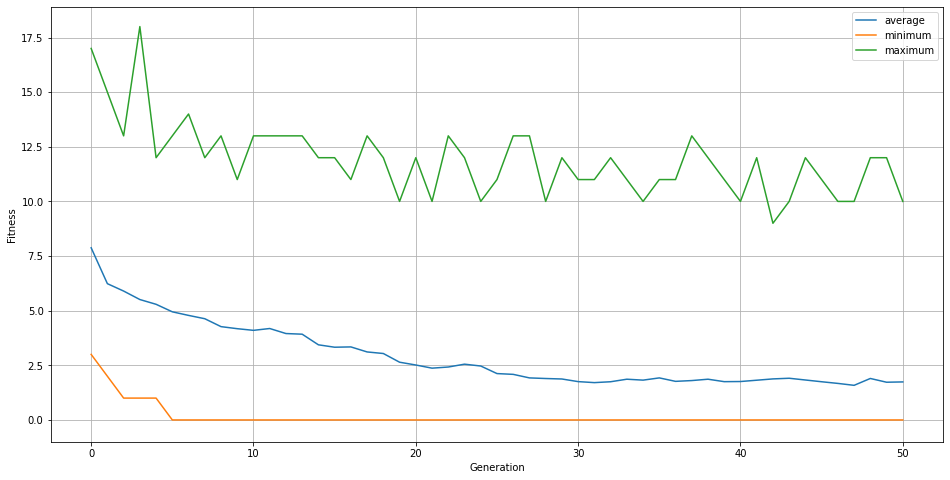

In [27]:
duration, log, fittest_individual_r8 = evolution(
    individual_generator=lambda: random.choices(range(8), k=8),
    fitness_evaluation=evaluate_row_indexed_fitness,
    population_size=500,
    generations=50,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 8 - 1, "indpb": .25})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [28]:
print(f"Positions: {fittest_individual_r8}")
print(f"Fitness: {abs(fittest_individual_r8.fitness.values[0])}")
display_row_grid(fittest_individual_r8)

Positions: [6, 1, 3, 0, 7, 4, 2, 5]
Fitness: 0.0


,1,2,3,4,5,6,7,8
1,,,,,,,👑,
2,,👑,,,,,,
3,,,,👑,,,,
4,👑,,,,,,,
5,,,,,,,,👑
6,,,,,👑,,,
7,,,👑,,,,,
8,,,,,,👑,,


### Evolutionary Algorithm on a 16x16 Board

#### Evolutionary Computation

Computed in 38.520 seconds


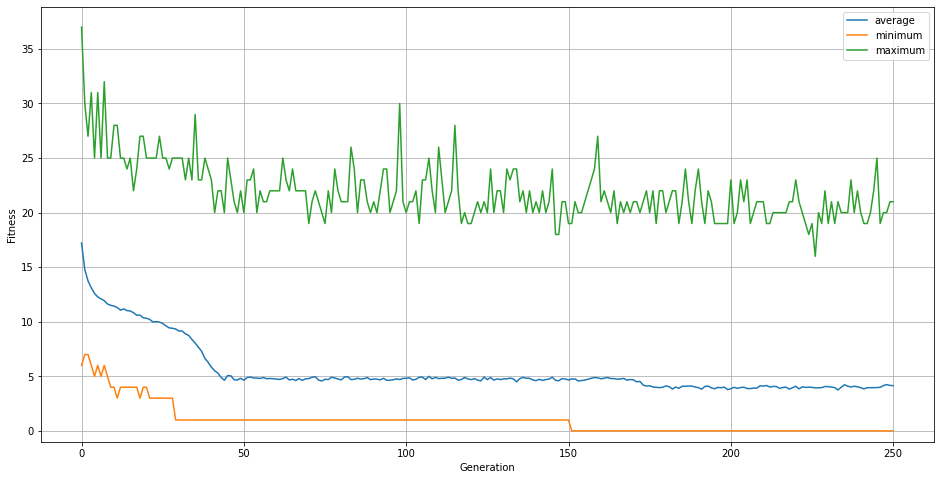

In [29]:
duration, log, fittest_individual_r16 = evolution(
    individual_generator=lambda: random.choices(range(16), k=16),
    fitness_evaluation=evaluate_row_indexed_fitness,
    population_size=2000,
    generations=250,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 16 - 1, "indpb": .25})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [30]:
print(f"Positions: {fittest_individual_r16}")
print(f"Fitness: {abs(fittest_individual_r16.fitness.values[0])}")
display_row_grid(fittest_individual_r16)

Positions: [10, 13, 1, 3, 9, 6, 2, 14, 12, 0, 5, 8, 15, 11, 4, 7]
Fitness: 0.0


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,,,,,,,,,,,👑,,,,,
2,,,,,,,,,,,,,,👑,,
3,,👑,,,,,,,,,,,,,,
4,,,,👑,,,,,,,,,,,,
5,,,,,,,,,,👑,,,,,,
6,,,,,,,👑,,,,,,,,,
7,,,👑,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,👑,
9,,,,,,,,,,,,,👑,,,
10,👑,,,,,,,,,,,,,,,


### Evolutionary Algorithm on a 32x32 Board

#### Evolutionary Computation

Computed in 244.370 seconds


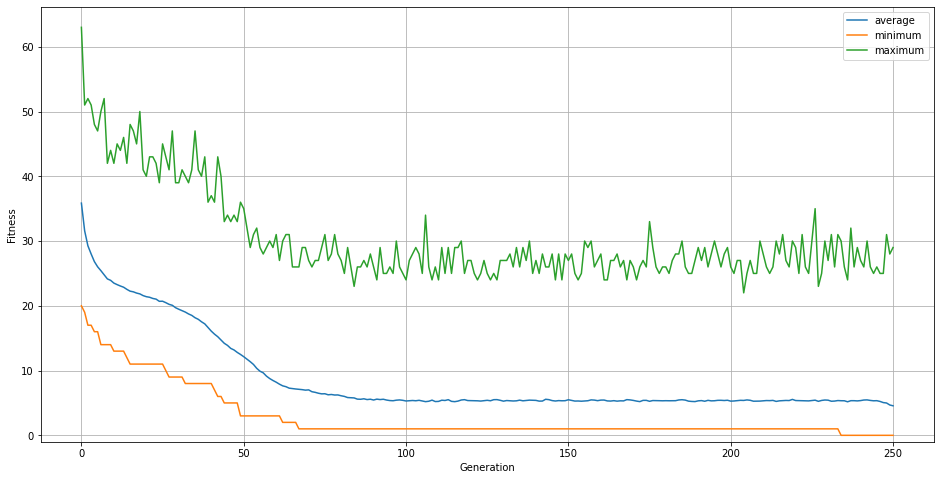

In [31]:
duration, log, fittest_individual_r32 = evolution(
    individual_generator=lambda: random.choices(range(32), k=32),
    fitness_evaluation=evaluate_row_indexed_fitness,
    population_size=5000,
    generations=250,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 32 - 1, "indpb": .125})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [32]:
print(f"Positions: {fittest_individual_r32}")
print(f"Fitness: {abs(fittest_individual_r32.fitness.values[0])}")
display_row_grid(fittest_individual_r32)

Positions: [15, 25, 8, 16, 9, 23, 28, 10, 0, 13, 26, 21, 2, 14, 31, 24, 4, 1, 11, 6, 17, 3, 18, 30, 7, 19, 12, 22, 5, 27, 29, 20]
Fitness: 0.0


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
1,,,,,,,,,,,,,,,,👑,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,,,,,,,,,,,👑,,,,,,
3,,,,,,,,,👑,,,,,,,,,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,,,👑,,,,,,,,,,,,,,,
5,,,,,,,,,,👑,,,,,,,,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,,,,,,,,,,👑,,,,,,,,
7,,,,,,,,,,,,,,,,,,,,,,,,,,,,,👑,,,
8,,,,,,,,,,,👑,,,,,,,,,,,,,,,,,,,,,
9,👑,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,,,,,,,,,,,,,,👑,,,,,,,,,,,,,,,,,,


<hr style="border-top: 2px solid #444">

## IV. Conclusion
